In [13]:
import librosa
import numpy as np
import pandas as pd
import pickle
import os
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform
import scipy.signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [3]:
def make_key_invariant_chromagram(y, sr):
    # Compute the chromagram
    chromagram = librosa.feature.chroma_cqt(y=y, sr=sr, bins_per_octave=24)
    
    # Calculate the chroma values to determine the key
    chroma_vals = [np.sum(chromagram[i]) for i in range(12)]
    pitches = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    keyfreqs = {pitches[i]: chroma_vals[i] for i in range(12)}
    
    # Define major and minor profiles for key correlation
    maj_profile = [6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
    min_profile = [6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]
    
    # Compute correlations for all keys
    maj_key_corrs = [np.corrcoef(maj_profile, [keyfreqs.get(pitches[(i + m) % 12]) for m in range(12)])[1,0] for i in range(12)]
    min_key_corrs = [np.corrcoef(min_profile, [keyfreqs.get(pitches[(i + m) % 12]) for m in range(12)])[1,0] for i in range(12)]
    keys = [p + ' major' for p in pitches] + [p + ' minor' for p in pitches]
    key_corrs = dict(zip(keys, maj_key_corrs + min_key_corrs))
    
    # Identify the key with the highest correlation
    key = max(key_corrs, key=key_corrs.get)
    
    # Determine tonic index and make chromagram key-invariant
    tonic = key.split()[0]
    tonic_index = pitches.index(tonic)
    key_invariant_chromagram = np.roll(chromagram, -tonic_index, axis=0)
    
    return key_invariant_chromagram

In [11]:
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
directory = '../data/pkl/combined_features'
if not os.path.exists(directory):
    os.makedirs(directory)

# Loop through each unique SongID in the DataFrame
for song_id in tqdm(df['SongID'].unique(), desc="Processing..."):
    data = df.loc[df['SongID'] == song_id]
    audio_path = f'../data/audio_files/processed/{song_id}.mp3'
    y, sr = librosa.load(audio_path, sr=None)
    y_harm, y_perc = librosa.effects.hpss(y)
    # Compute features
    rms = librosa.feature.rms(y=y)
    rms_normalized = (rms - np.min(rms, axis=1, keepdims=True)) / (np.max(rms, axis=1, keepdims=True) - np.min(rms, axis=1, keepdims=True))
    C = np.abs(librosa.cqt(y=y, sr=sr))
    onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    tgr = librosa.feature.tempogram_ratio(y=y_perc, sr=sr)
    # Key-invariant chromagram
    key_invariant_chromagram = make_key_invariant_chromagram(y=y_harm, sr=sr)
    S = librosa.feature.melspectrogram(y=y_harm, sr=sr, n_mels=128, fmax=8000)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
    mfcc_min = mfcc.min(axis=1, keepdims=True)
    mfcc_max = mfcc.max(axis=1, keepdims=True)
    mfcc_scaled = (mfcc - mfcc_min) / (mfcc_max - mfcc_min)
    combined_features = np.vstack((rms_normalized, key_invariant_chromagram, tgr, mfcc_scaled))
    # Define the path for the pickle file
    pickle_path = os.path.join(directory, f'{song_id}_combined_features.pkl')
    
    # Save combined_features to a pickle file
    with open(pickle_path, 'wb') as file:
        pickle.dump(combined_features, file)

Processing...: 100%|██████████| 332/332 [2:30:03<00:00, 27.12s/it]  


In [ ]:
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
directory = '../data/pkl/combined_features'
# Initialize a list to store the results
results = []

# Loop through each unique SongID in the DataFrame
for song_id in tqdm(df['SongID'].unique(), desc="Processing..."):
    data = df.loc[df['SongID'] == song_id]
    audio_path = f'../data/audio_files/processed/{song_id}.mp3'
    y, sr = librosa.load(audio_path, sr=None)
    y_harm, y_perc = librosa.effects.hpss(y)
    # Compute features
    rms = librosa.feature.rms(y=y)
    rms_normalized = (rms - np.min(rms, axis=1, keepdims=True)) / (np.max(rms, axis=1, keepdims=True) - np.min(rms, axis=1, keepdims=True))
    C = np.abs(librosa.cqt(y=y, sr=sr))
    onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
    tgr = librosa.feature.tempogram_ratio(y=y_perc, sr=sr)
    # Key-invariant chromagram
    key_invariant_chromagram = make_key_invariant_chromagram(y=y_harm, sr=sr)
    S = librosa.feature.melspectrogram(y=y_harm, sr=sr, n_mels=128, fmax=8000)
    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
    mfcc_min = mfcc.min(axis=1, keepdims=True)
    mfcc_max = mfcc.max(axis=1, keepdims=True)
    mfcc_scaled = (mfcc - mfcc_min) / (mfcc_max - mfcc_min)
    combined_features = np.vstack((rms_normalized, key_invariant_chromagram, tgr, mfcc_scaled))
    
    bpm = data['sp_tempo'].values[0] if not pd.isna(data['sp_tempo'].values[0]) else tempo
    if bpm == 0:
        bpm = tempo
    if bpm > 140:
        bpm /= 2
    if bpm <= 70:
        bpm *= 2
    # Time signature
    time_signature = data['sp_time_signature'].values[0] if not pd.isna(data['sp_time_signature'].values[0]) else 4
    time_signature = int(time_signature) if time_signature != 0 else 4
    beat_interval_in_frames = int(librosa.time_to_frames(60/bpm, sr=sr))
    measure_interval_in_frames = beat_interval_in_frames * time_signature
    
    combined_ssm = squareform(pdist(combined_features.T, 'cosine'))
    lag = 4
    novelty_curve_lag = np.abs(np.diff(np.diag(combined_ssm, k=lag), prepend=0))
    sigma = 15  # Adjust sigma as needed for smoothing
    prominence = 0.002
    novelty_distance = measure_interval_in_frames*15
    smoothed_novelty_lag = scipy.ndimage.gaussian_filter1d(novelty_curve_lag, sigma=sigma)
    exclusion_zone_length = measure_interval_in_frames * 4
    smoothed_novelty_lag[:exclusion_zone_length] = 0
    smoothed_novelty_lag[-exclusion_zone_length:] = 0
    peaks_lag, _ = scipy.signal.find_peaks(smoothed_novelty_lag, prominence=0.007, distance=novelty_distance)
    
    # Initialize lists to store segments and their capture status
    segment_frames = peaks_lag.tolist()  # Detected boundary frames as a list
    labeled_frames = []
    captured = []
    chorus_data = data.loc[data['label'] == 'chorus']
    for _, row in chorus_data.iterrows():
        if row['label'] == 'chorus':
            # Store start and end frames of labeled choruses
            labeled_frames.append((row['start_frame'], row['end_frame']))

            # Check if the labeled chorus is captured by any detected segment
            is_captured = 0  # Default to not captured
            for peak in peaks_lag:
                segment_start = peak - measure_interval_in_frames
                segment_end = peak + measure_interval_in_frames
                if row['start_frame'] >= segment_start and row['end_frame'] <= segment_end:
                    is_captured = 1  # Mark as captured if within one measure distance
                    break  # Exit loop once captured
            captured.append(is_captured)

    # Append results for the current song
    results.append({
        'SongID': song_id,
        'segment_frames': segment_frames,
        'labeled_frames': labeled_frames,
        'captured': captured
    })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

In [ ]:
# Initialize counters for captured labels and total labels
total_captured = 0
total_labels = 0

# Loop through each row in the results DataFrame
for index, row in results_df.iterrows():
    captured_count = sum(row['captured'])  # Sum of captured choruses for the song
    total_labels_for_song = len(row['captured'])  # Total labeled choruses for the song
    
    # Update the overall totals
    total_captured += captured_count
    total_labels += total_labels_for_song

# Calculate the percentage of labels that were fully captured
# Handle the case where total_labels is zero by using a conditional expression
percentage_captured = (total_captured / total_labels) * 100 if total_labels > 0 else 0

# Print the result
print(f"Percentage of labels that were fully captured: {percentage_captured:.2f}%")

In [4]:
audio_path = '../data/audio_files/processed/2.mp3'
df = pd.read_csv('../data/dataframes/clean_labeled.csv')
data = df.loc[df['SongID']==2]
sp_tempo = data['sp_tempo'].values[0]
y, sr = librosa.load(audio_path, sr=None)
duration = librosa.get_duration(y=y, sr=sr, hop_length=512)
# Compute the RMS feature
rms = librosa.feature.rms(y=y)
rms_normalized = (rms - np.min(rms, axis=1, keepdims=True)) / (np.max(rms, axis=1, keepdims=True) - np.min(rms, axis=1, keepdims=True))

C = np.abs(librosa.cqt(y=y, sr=sr))
onset_env = librosa.onset.onset_strength(sr=sr, S=librosa.amplitude_to_db(C, ref=np.max))
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
tempogram = librosa.feature.tempogram(onset_envelope=onset_env, sr=sr)
tgr = librosa.feature.tempogram_ratio(tg=tempogram, sr=sr)
# Key-invariant chromagram
key_invariant_chromagram = make_key_invariant_chromagram(y, sr)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(S))
mfcc_min = mfcc.min(axis=1, keepdims=True)
mfcc_max = mfcc.max(axis=1, keepdims=True)
mfcc_scaled = (mfcc - mfcc_min) / (mfcc_max - mfcc_min)
combined_features = np.vstack((rms_normalized, key_invariant_chromagram, tgr, mfcc_scaled))

# Create a measure grid
# Tempo
bpm = data['sp_tempo'].values[0] if not pd.isna(data['sp_tempo'].values[0]) else tempo
if bpm == 0:
    bpm = tempo
if bpm > 140:
    bpm /= 2
if bpm <= 70:
    bpm *= 2
# Time signature
time_signature = data['sp_time_signature'].values[0] if not pd.isna(data['sp_time_signature'].values[0]) else 4
time_signature = int(time_signature) if time_signature != 0 else 4

duration_in_frames = len(combined_features)
beat_interval_in_frames = int(librosa.time_to_frames(60/bpm, sr=sr))
measure_interval_in_frames = beat_interval_in_frames * time_signature
anchor_frame = find_anchor_frame(beats, bpm, sr)
beat_grid, measure_grid = create_beat_grid(beats, anchor_frame, sr, beat_interval_in_frames, time_signature, duration_in_frames)

In [ ]:
combined_ssm = squareform(pdist(combined_features.T, 'cosine'))

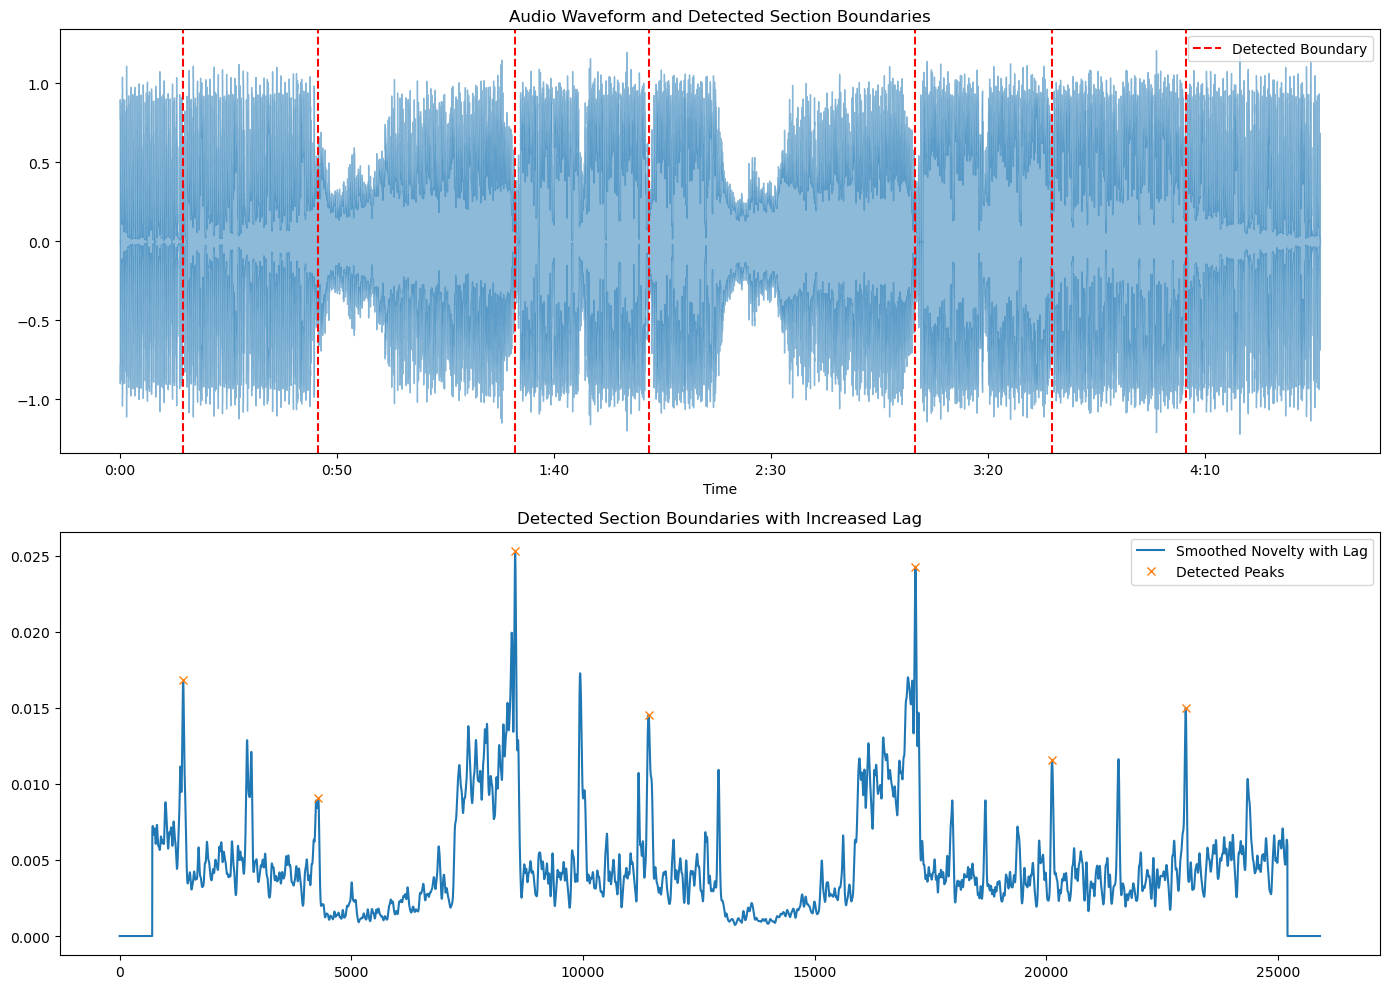

In [7]:
# Compute novelty curve 
lag = 4
novelty_curve_lag = np.abs(np.diff(np.diag(combined_ssm, k=lag), prepend=0))
sigma = 15  # Adjust sigma as needed for smoothing
prominence = 0.002
novelty_distance = measure_interval_in_frames*15
smoothed_novelty_lag = scipy.ndimage.gaussian_filter1d(novelty_curve_lag, sigma=sigma)
# Calculate the exclusion zone length
exclusion_zone_length = measure_interval_in_frames * 4

# Modify the start and end of the smoothed_novelty_lag to prevent peak detection in these regions
smoothed_novelty_lag[:exclusion_zone_length] = 0
smoothed_novelty_lag[-exclusion_zone_length:] = 0

# Find peaks in the smoothed novelty curve with adjusted parameters
peaks_lag, _ = scipy.signal.find_peaks(smoothed_novelty_lag, prominence=0.007, distance=novelty_distance)  


# Set up the figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 10))  # 2 rows, 1 column
# Plot 1: Audio Waveform and Detected Section Boundaries
librosa.display.waveshow(y, sr=sr, alpha=0.5, ax=axs[0])
axs[0].set_title('Audio Waveform and Detected Section Boundaries')
times = librosa.frames_to_time(peaks_lag, sr=sr)
for time in times:
    axs[0].axvline(x=time, color='r', linestyle='--', label='Detected Boundary' if time == times[0] else "")
axs[0].legend()

# Plot 2: Detected Peaks on the Novelty Curve
axs[1].plot(smoothed_novelty_lag, label='Smoothed Novelty with Lag')
axs[1].plot(peaks_lag, smoothed_novelty_lag[peaks_lag], "x", label='Detected Peaks')
axs[1].set_title('Detected Section Boundaries with Increased Lag')
axs[1].legend()

# Show the figure
plt.tight_layout()  # Adjusts subplot params to give specified padding
plt.show()

In [8]:
df

,SongID,start_time,end_time,start_frame,end_frame,label,TrackName,Artists,Genre,FilePath,...,sp_loudness,sp_speechiness,sp_acousticness,sp_instrumentalness,sp_liveness,sp_valence,sp_tempo,sp_time_signature,sp_genre,sampling_rate
0,1,0.0,61.000000,0,5718,other,Bass Inside,AC Slater,Bass House,..\data\audio_files\processed\1.mp3,...,-6.838,0.0499,0.00112,0.839,0.608,0.464,126.007,4.0,"electro house, brostep, bass house, fidget house",48000
1,1,61.0,121.900000,5718,11428,chorus,Bass Inside,AC Slater,Bass House,..\data\audio_files\processed\1.mp3,...,-6.838,0.0499,0.00112,0.839,0.608,0.464,126.007,4.0,"electro house, brostep, bass house, fidget house",48000
2,1,121.9,167.700000,11428,15721,other,Bass Inside,AC Slater,Bass House,..\data\audio_files\processed\1.mp3,...,-6.838,0.0499,0.00112,0.839,0.608,0.464,126.007,4.0,"electro house, brostep, bass house, fidget house",48000
3,1,167.7,228.600000,15721,21431,chorus,Bass Inside,AC Slater,Bass House,..\data\audio_files\processed\1.mp3,...,-6.838,0.0499,0.00112,0.839,0.608,0.464,126.007,4.0,"electro house, brostep, bass house, fidget house",48000
4,1,228.6,259.995011,21431,24374,other,Bass Inside,AC Slater,Bass House,..\data\audio_files\processed\1.mp3,...,-6.838,0.0499,0.00112,0.839,0.608,0.464,126.007,4.0,"electro house, brostep, bass house, fidget house",48000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1810,553,0.0,30.700000,0,2878,other,Tunnel Vision - Don Diablo Edit,"Zonderling, Don Diablo",Dutch House,..\data\audio_files\processed\553.mp3,...,-4.101,0.1110,0.23300,0.470,0.110,0.365,126.001,4.0,"dutch house, edm, future house, pop dance, sky...",48000
1811,553,30.7,76.400000,2878,7162,chorus,Tunnel Vision - Don Diablo Edit,"Zonderling, Don Diablo",Dutch House,..\data\audio_files\processed\553.mp3,...,-4.101,0.1110,0.23300,0.470,0.110,0.365,126.001,4.0,"dutch house, edm, future house, pop dance, sky...",48000
1812,553,76.4,129.800000,7162,12168,other,Tunnel Vision - Don Diablo Edit,"Zonderling, Don Diablo",Dutch House,..\data\audio_files\processed\553.mp3,...,-4.101,0.1110,0.23300,0.470,0.110,0.365,126.001,4.0,"dutch house, edm, future house, pop dance, sky...",48000
1813,553,129.8,190.700000,12168,17878,chorus,Tunnel Vision - Don Diablo Edit,"Zonderling, Don Diablo",Dutch House,..\data\audio_files\processed\553.mp3,...,-4.101,0.1110,0.23300,0.470,0.110,0.365,126.001,4.0,"dutch house, edm, future house, pop dance, sky...",48000


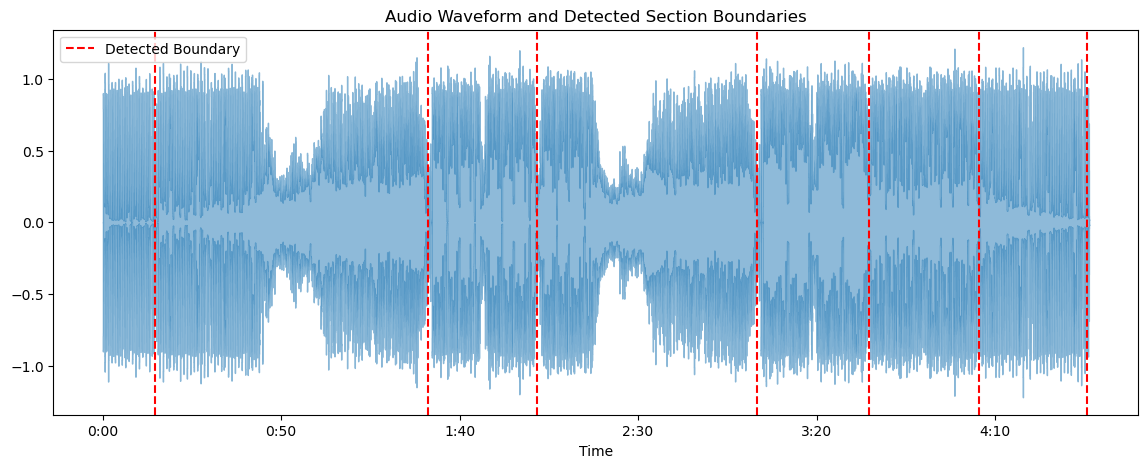

In [97]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.5)
plt.title('Audio Waveform and Detected Section Boundaries')

# Convert peaks from frames to time to overlay them on the waveform
times = librosa.frames_to_time(peaks_lag, sr=sr)

# Plot the detected section boundaries
for time in times:
    plt.axvline(x=time, color='r', linestyle='--', label='Detected Boundary' if time == times[0] else "")

plt.legend()
plt.show()

In [21]:
def si_plca(combined_features, rank=4, win=32, iterations=50):
    F, T = combined_features.shape  # Feature dimensions
    W = np.random.rand(F, rank, win) + 1e-6  # Basis functions
    H = np.random.rand(rank, T) + 1e-6  # Activations
    Z = np.random.rand(rank) + 1e-6  # Mixing weights
    W /= np.sum(W, axis=0, keepdims=True)  # Normalize W
    H /= np.sum(H, axis=0, keepdims=True)  # Normalize H

    for it in range(iterations):
        # E-step: Estimate latent component activations
        # Compute the approximate reconstruction of combined_features
        reconstruction = np.zeros_like(combined_features)
        for k in range(rank):
            for shift in range(win):
                # Shift W[k] and multiply by H[k], sum over k
                W_shifted = np.roll(W[:, k, :], shift, axis=1)
                reconstruction += Z[k] * W_shifted[:, :T] * H[k, :]
        
        # Normalize reconstruction to prevent division by zero
        reconstruction += 1e-10

        # M-step: Update parameters W, H, Z to maximize likelihood
        for k in range(rank):
            for shift in range(win):
                W_shifted = np.roll(W[:, k, :], shift, axis=1)
                update_factor = combined_features / reconstruction
                H[k, :] *= np.sum(Z[k] * W_shifted[:, :T] * update_factor, axis=0)
                W[:, k, shift] *= np.sum(Z[k] * H[k, :] * update_factor, axis=1)

        # Normalize W and H again after updates
        W /= np.sum(W, axis=(0, 2), keepdims=True)
        H /= np.sum(H, axis=1, keepdims=True)
        Z = np.sum(H, axis=1)
        Z /= np.sum(Z)  # Re-normalize Z to sum to 1

    return W, H, Z

In [22]:
# Assuming combined_features is your input matrix (F x T)
W, H, Z = si_plca(combined_features, rank=4, win=32, iterations=50)


ValueError: operands could not be broadcast together with shapes (26,32) (25915,) 